## dynunet pipeline with NeuroI ROI dataset
* medicaldecathlon 을 이용한 4D multi classes segmentation. -> 동작함.
* 아래 파이프라인을 바탕으로 현재 NEUROI ROI 데이터셋을 태워서 뭐가 문제가 있는지 확인해 보자.

In [1]:
import logging
import os
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import torch
import torch.distributed as dist
from monai.config import print_config
from monai.handlers import (
    CheckpointSaver,
    LrScheduleHandler,
    MeanDice,
    StatsHandler,
    ValidationHandler,
    from_engine,
)
from monai.inferers import SimpleInferer, SlidingWindowInferer
from monai.losses import DiceCELoss
from monai.utils import set_determinism
from torch.nn.parallel import DistributedDataParallel

from create_dataset import get_data_ke
from create_network import get_network_ke
from evaluator import DynUNetEvaluator
# from task_params import data_loader_params, patch_size
from trainer import DynUNetTrainer

from monai.utils import first
import numpy as np


In [2]:

# 	train.py -fold $fold -train_num_workers 4 -interval 10 -num_samples 2 \
# 	-learning_rate $lr -max_epochs 3000 -task_id 01 -pos_sample_num 1 \
# 	-expr_name baseline -tta_val True -multi_gpu True

In [3]:
# task_id = "01"
# fold = 0
# root_dir = "/data/kehyeong/project/MONAI_examples/data/brats/"
# datalist_path ="config/"

config = "/work/NeuroI-models/ke-monai/config_gpu/config_roi_earlystop_toy_220209.yaml"
train_dataset = "/work/NeuroI-models/ke-monai/data/roi/dataset_train_roi_toy2.csv"
val_dataset = "/work/NeuroI-models/ke-monai/data/roi/dataset_val_roi_toy2.csv"
log_file = "/data/train/running/l/model_roi_toy_220210/train.log"
checkpoint = None

## [아래 config에서 불러 오는 params]
# max_epochs = 1500
# num_samples = 4
# train_num_workers = 4
# val_num_workers = 2

patch_size = [64, 64, 64] # [128, 128, 128]    #[96, 96, 96]
learning_rate = 1.0e-3    # working: 1e-1
interval = 2
multi_gpu = False  # True
local_rank = 0

## [Dafault setting] - 변경 필요 없음
window_mode = "gaussian"  # "constant", "gaussian"
eval_overlap = 0.5
tta_val = True
batch_dice = False
lr_decay_flag = False
spacing = [1.0, 1.0, 1.0]
deep_supr_num = 3
expr_name = "baseline"
####################################


# pos_sample_num = 1
# neg_sample_num = 1
# cache_rate = 1.0


# mode = "train"
# checkpoint = None
# amp = False
# lr_decay = False
# tta_val = True
# batch_dice = False
# determinism_flag = False
# determinism_seed = 0
# expr_name = "baseline"

In [4]:
from config import get_config
from dataset_roi import get_train_loader, get_val_loader
import monai

local_rank = local_rank
log_file = log_file
train_dataset = train_dataset
val_dataset = val_dataset
checkpoint = checkpoint

multi_gpu_flag = multi_gpu
config = get_config(config)
data_dir = config["data_dir"]
image_file_path = config["image_file_path"]
label_file_path = config["label_file_path"]
# brain_file_path = config["brain_file_path"]
mask_file_path = config["mask_file_path"]
random_seed = config["random_seed"]
max_epochs = config["train"]["max_epoches"]
num_classes = config["num_classes"]

# patch_size = tuple(config["patch_size"])
lr = config["train"]["lr"]
train_batch_size = config["train"]["batch_size"]
train_num_samples = config["train"]["num_samples"]
train_num_workers = config["train"]["num_workers"]
# val_interval = config["train"]["val_interval"]
val_batch_size = config["val"]["batch_size"]
sw_batch_size = val_batch_size    # for evaluator
val_num_workers = config["val"]["num_workers"]
log_dir = config["log_dir"]
model_dir = config["model_dir"]
mlflow_dir = os.path.join(log_dir, "mlruns")

amp_flag = (True if monai.utils.get_torch_version_tuple() >= (1, 6) else False,)

monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"

if multi_gpu_flag:
    dist.init_process_group(backend="nccl", init_method="env://")
    device = torch.device(f"cuda:{local_rank}")
    torch.cuda.set_device(device)
else:
#     device = torch.device("cpu")
    device = torch.device("cuda")


#
# data loader
#
train_loader = get_train_loader(
    data_dir=data_dir,
    id_file=train_dataset,
    image_file_pattern=image_file_path,
    label_file_pattern=label_file_path,
    # brain_file_pattern=brain_file_path,
    mask_file_pattern=mask_file_path,
    batch_size=train_batch_size,
    patch_size=patch_size,
    num_samples=train_num_samples,
    num_workers=train_num_workers,
    multi_gpu_flag=multi_gpu_flag
)
val_loader = get_val_loader(
    data_dir=data_dir,
    id_file=val_dataset,
    image_file_pattern=image_file_path,
    label_file_pattern=label_file_path,
    # brain_file_pattern=brain_file_path,
    mask_file_pattern=mask_file_path,
    batch_size=val_batch_size,
    num_workers=val_num_workers,
    multi_gpu_flag=multi_gpu_flag
)

{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0217 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0217 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0217 02_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0217 03_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0005 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0005 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0005 02_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0005 03_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0419 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0419 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0419 02_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0419 03_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmente

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████| 52/52 [00:28<00:00,  1.84it/s]


{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0454 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0454 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0303 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0303 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0197 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0197 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0350 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0350 01_d
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0317 00_0
{dir}/s_{id}_{aid}_b.nii.gz /data/train/running/l/input_augmented SU0317 01_d


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


In [5]:
num_classes

109

In [6]:
test_data = first(train_loader)
print(test_data.keys())
print('image, label shape')
print(test_data['image'].shape)
print(test_data['label'].shape)
print(test_data['image'].dtype)
print(test_data['label'].dtype)
print(np.unique(test_data['label']))
total_labels = np.unique(test_data['label'])
print(f'class 수 {len(total_labels)}')

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms', 'resample_flag', 'anisotrophy_flag'])
image, label shape
torch.Size([12, 1, 64, 64, 64])
torch.Size([12, 1, 64, 64, 64])
torch.float32
torch.uint8
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  20  21  23  24  25  26  27  28  29  30  31  32  33  34  36  37  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108]
class 수 104


In [7]:
for each in test_data['label']:
    print(each.shape)
    total_labels = np.unique(each)
    print(f'class 수 {len(total_labels)}')

torch.Size([1, 64, 64, 64])
class 수 32
torch.Size([1, 64, 64, 64])
class 수 54
torch.Size([1, 64, 64, 64])
class 수 50
torch.Size([1, 64, 64, 64])
class 수 48
torch.Size([1, 64, 64, 64])
class 수 52
torch.Size([1, 64, 64, 64])
class 수 31
torch.Size([1, 64, 64, 64])
class 수 52
torch.Size([1, 64, 64, 64])
class 수 28
torch.Size([1, 64, 64, 64])
class 수 63
torch.Size([1, 64, 64, 64])
class 수 70
torch.Size([1, 64, 64, 64])
class 수 42
torch.Size([1, 64, 64, 64])
class 수 38


**modicaldecatholon 파이프라인 참고**

```python
task_id = task_id
fold = fold
val_output_dir = "./runs_{}_fold{}_{}/".format(task_id, fold, expr_name)
log_filename = "nnunet_task{}_fold{}.log".format(task_id, fold)
log_filename = os.path.join(val_output_dir, log_filename)
interval = interval
learning_rate = learning_rate
max_epochs = max_epochs
multi_gpu_flag = multi_gpu
amp_flag = amp
lr_decay_flag = lr_decay
sw_batch_size = sw_batch_size
tta_val = tta_val
batch_dice = batch_dice
window_mode = window_mode
eval_overlap = eval_overlap
local_rank = local_rank
determinism_flag = determinism_flag
determinism_seed = determinism_seed
if determinism_flag:
    set_determinism(seed=determinism_seed)
    if local_rank == 0:
        print("Using deterministic training.")

# transforms
train_batch_size = data_loader_params[task_id]["batch_size"]
if multi_gpu_flag:
    dist.init_process_group(backend="nccl", init_method="env://")

    device = torch.device(f"cuda:{local_rank}")
    torch.cuda.set_device(device)
else:
    device = torch.device("cuda:3")

print(device)

properties, val_loader = get_data_ke(fold, task_id, root_dir, datalist_path, pos_sample_num,
                                     neg_sample_num, num_samples, multi_gpu, val_num_workers,
                                     cache_rate, train_num_workers, mode="validation")
_, train_loader = get_data_ke(fold, task_id, root_dir, datalist_path, pos_sample_num,
                              neg_sample_num, num_samples, multi_gpu, val_num_workers,
                              cache_rate, train_num_workers, 
                              batch_size=train_batch_size, mode="train")

## ke
test_data = first(train_loader)
print(test_data.keys())
print('image, label shape')
print(test_data['image'].shape)
print(test_data['label'].shape)
print(test_data['image'].dtype)
print(test_data['label'].dtype)
print(np.unique(test_data['label']))
```

In [8]:
properties = {
    'modality': [0],
    'labels': np.arange(num_classes)
}
n_class = len(properties["labels"])
in_channels = len(properties["modality"])
in_channels, n_class

(1, 109)

In [9]:
# produce the network
val_output_dir = "./runs_fold{}_{}/".format(1, expr_name)
checkpoint = checkpoint
net = get_network_ke(properties, patch_size, spacing, deep_supr_num, 
                     val_output_dir, checkpoint)
net = net.to(device)
print(net)

if multi_gpu_flag:
    net = DistributedDataParallel(module=net, device_ids=[device])
# net = DistributedDataParallel(module=net, device_ids=[device])

optimizer = torch.optim.SGD(
    net.parameters(),
    lr=learning_rate,
    momentum=0.99,
    weight_decay=3e-5,
    nesterov=True,
)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda epoch: (1 - epoch / max_epochs) ** 0.9
)
# produce evaluator
val_handlers = [
    StatsHandler(output_transform=lambda x: None),
    CheckpointSaver(
        save_dir=val_output_dir, save_dict={"net": net}, save_key_metric=True
    ),
]

evaluator = DynUNetEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    num_classes=len(properties["labels"]),
    inferer=SlidingWindowInferer(
        roi_size=patch_size,
        sw_batch_size=sw_batch_size,
        overlap=eval_overlap,
        mode=window_mode,
    ),
    postprocessing=None,
    key_val_metric={
        "val_mean_dice": MeanDice(
            include_background=False,
            output_transform=from_engine(["pred", "label"]),
        )
    },
    val_handlers=val_handlers,
    amp=amp_flag,
    tta_val=tta_val,
)

# produce trainer
loss = DiceCELoss(to_onehot_y=True, softmax=True, batch=batch_dice)
train_handlers = []
if lr_decay_flag:
    train_handlers += [LrScheduleHandler(lr_scheduler=scheduler, print_lr=True)]

train_handlers += [
    ValidationHandler(validator=evaluator, interval=interval, epoch_level=True),
    StatsHandler(
#         tag_name="train_loss", output_transform=from_engine(["loss"], first=True)
        tag_name="train_loss", output_transform=lambda x: x["loss"]
    ),
]

trainer = DynUNetTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=optimizer,
    loss_function=loss,
    inferer=SimpleInferer(),
    postprocessing=None,
    key_train_metric=None,
    train_handlers=train_handlers,
    amp=amp_flag,
)

if local_rank > 0:
    evaluator.logger.setLevel(logging.WARNING)
    trainer.logger.setLevel(logging.WARNING)

logger = logging.getLogger()

formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

# Setup file handler
fhandler = logging.FileHandler(log_file)
fhandler.setLevel(logging.INFO)
fhandler.setFormatter(formatter)

logger.addHandler(fhandler)

chandler = logging.StreamHandler()
chandler.setLevel(logging.INFO)
chandler.setFormatter(formatter)
logger.addHandler(chandler)

logger.setLevel(logging.INFO)

trainer.run()

2022-02-16 05:35:46,665 - ignite.engine.engine.DynUNetTrainer - INFO - Engine run resuming from iteration 0, epoch 0 until 1500 epochs


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

2022-02-16 05:35:56,973 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 1/17 -- train_loss: 11.4669 
2022-02-16 05:35:57,280 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 2/17 -- train_loss: 9.7904 
2022-02-16 05:35:57,572 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 3/17 -- train_loss: 8.3554 
2022-02-16 05:35:57,905 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 4/17 -- train_loss: 6.9775 
2022-02-16 05:35:58,284 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 5/17 -- train_loss: 7.1816 
2022-02-16 05:35:58,576 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 6/17 -- train_loss: 6.2885 
2022-02-16 05:35:58,868 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 7/17 -- train_loss: 6.5609 
2022-02-16 05:35:59,414 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 1/1500, Iter: 8/17 -- train_loss: 5.7142 
2022-02-16 05:35:59,759 - ignite.engine

2022-02-16 05:40:20,907 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 7/17 -- train_loss: 5.3351 
2022-02-16 05:40:21,200 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 8/17 -- train_loss: 5.2552 
2022-02-16 05:40:21,543 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 9/17 -- train_loss: 5.1195 
2022-02-16 05:40:21,883 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 10/17 -- train_loss: 5.6687 
2022-02-16 05:40:22,223 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 11/17 -- train_loss: 5.2802 
2022-02-16 05:40:22,559 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 12/17 -- train_loss: 5.2207 
2022-02-16 05:40:22,896 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 13/17 -- train_loss: 5.6938 
2022-02-16 05:40:23,236 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 4/1500, Iter: 14/17 -- train_loss: 5.2398 
2022-02-16 05:40:23,576 - ignite.en

2022-02-16 05:47:11,424 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 7/17 -- train_loss: 4.8212 
2022-02-16 05:47:11,766 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 8/17 -- train_loss: 5.0833 
2022-02-16 05:47:12,115 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 9/17 -- train_loss: 5.2953 
2022-02-16 05:47:12,456 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 10/17 -- train_loss: 4.9202 
2022-02-16 05:47:12,797 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 11/17 -- train_loss: 5.1325 
2022-02-16 05:47:13,138 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 12/17 -- train_loss: 4.9771 
2022-02-16 05:47:13,482 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 13/17 -- train_loss: 4.7850 
2022-02-16 05:47:13,821 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 7/1500, Iter: 14/17 -- train_loss: 5.5079 
2022-02-16 05:47:14,163 - ignite.en

2022-02-16 05:50:48,020 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 10/1500, Iter: 13/17 -- train_loss: 4.5861 
2022-02-16 05:50:48,357 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 10/1500, Iter: 14/17 -- train_loss: 5.0723 
2022-02-16 05:50:48,693 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 10/1500, Iter: 15/17 -- train_loss: 4.7356 
2022-02-16 05:50:49,044 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 10/1500, Iter: 16/17 -- train_loss: 4.1773 
2022-02-16 05:50:49,399 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 10/1500, Iter: 17/17 -- train_loss: 4.4306 
2022-02-16 05:50:49,400 - ignite.engine.engine.DynUNetEvaluator - INFO - Engine run resuming from iteration 0, epoch 9 until 10 epochs
2022-02-16 05:54:03,311 - ignite.engine.engine.DynUNetEvaluator - INFO - Epoch[10] Metrics -- val_mean_dice: 0.0135 
2022-02-16 05:54:03,324 - ignite.engine.engine.DynUNetEvaluator - INFO - Key metric: val_mean_dice best value: 0.016296565532684326 at epo

2022-02-16 05:57:38,435 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 13/1500, Iter: 13/17 -- train_loss: 4.3633 
2022-02-16 05:57:38,779 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 13/1500, Iter: 14/17 -- train_loss: 4.2389 
2022-02-16 05:57:39,122 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 13/1500, Iter: 15/17 -- train_loss: 4.4075 
2022-02-16 05:57:39,467 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 13/1500, Iter: 16/17 -- train_loss: 4.3400 
2022-02-16 05:57:39,807 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 13/1500, Iter: 17/17 -- train_loss: 4.6156 
2022-02-16 05:57:39,808 - ignite.engine.engine.DynUNetTrainer - INFO - Key metric: None best value: -1 at epoch: -1
2022-02-16 05:57:39,809 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch[13] Complete. Time taken: 00:00:08
2022-02-16 05:57:41,732 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 14/1500, Iter: 1/17 -- train_loss: 4.3844 
2022-02-16 05:57:42,100 - ignite.engine.e

2022-02-16 06:01:23,723 - ignite.engine.engine.DynUNetEvaluator - INFO - Engine run resuming from iteration 0, epoch 15 until 16 epochs
2022-02-16 06:04:22,493 - ignite.engine.engine.DynUNetEvaluator - INFO - Got new best metric of val_mean_dice: 0.02229660376906395
2022-02-16 06:04:22,613 - ignite.engine.engine.DynUNetEvaluator - INFO - Epoch[16] Metrics -- val_mean_dice: 0.0223 
2022-02-16 06:04:22,618 - ignite.engine.engine.DynUNetEvaluator - INFO - Key metric: val_mean_dice best value: 0.02229660376906395 at epoch: 16
2022-02-16 06:04:22,959 - ignite.engine.engine.DynUNetEvaluator - INFO - Epoch[16] Complete. Time taken: 00:02:58
2022-02-16 06:04:22,960 - ignite.engine.engine.DynUNetEvaluator - INFO - Engine run complete. Time taken: 00:02:59
2022-02-16 06:04:23,378 - ignite.engine.engine.DynUNetTrainer - INFO - Key metric: None best value: -1 at epoch: -1
2022-02-16 06:04:23,380 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch[16] Complete. Time taken: 00:03:13
2022-02-16 06:0

2022-02-16 06:08:01,790 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 19/1500, Iter: 17/17 -- train_loss: 3.9278 
2022-02-16 06:08:01,792 - ignite.engine.engine.DynUNetTrainer - INFO - Key metric: None best value: -1 at epoch: -1
2022-02-16 06:08:01,793 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch[19] Complete. Time taken: 00:00:09
2022-02-16 06:08:04,057 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 20/1500, Iter: 1/17 -- train_loss: 3.8868 
2022-02-16 06:08:04,353 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 20/1500, Iter: 2/17 -- train_loss: 4.1255 
2022-02-16 06:08:04,688 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 20/1500, Iter: 3/17 -- train_loss: 3.8831 
2022-02-16 06:08:05,069 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 20/1500, Iter: 4/17 -- train_loss: 4.0888 
2022-02-16 06:08:05,404 - ignite.engine.engine.DynUNetTrainer - INFO - Epoch: 20/1500, Iter: 5/17 -- train_loss: 4.0090 
2022-02-16 06:08:05,696 - ignite.engine.engin

KeyboardInterrupt: 

In [11]:
test_data = first(train_loader)
print(test_data.keys())
print('image, label shape')
print(test_data['image'].shape)
print(test_data['label'].shape)
print(test_data['image'].dtype)
print(test_data['label'].dtype)
print(np.unique(test_data['label']))
print(len(np.unique(test_data['label'])))

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms', 'resample_flag', 'anisotrophy_flag'])
image, label shape
torch.Size([12, 1, 64, 64, 64])
torch.Size([12, 1, 64, 64, 64])
torch.float32
torch.uint8
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  20  21  23  25  26  27  28  29  30  31  32  33  34  36  37  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  95  96
  97  98  99 100 101 102 103 104 105 106 107 108]
102


In [12]:
test_data['label'].numel(), 24*96*96*96

(3145728, 21233664)

In [13]:
import matplotlib.pyplot as plt

torch.Size([12, 1, 64, 64, 64]) torch.Size([12, 1, 64, 64, 64])
image shape: torch.Size([64, 64, 64]), label shape: torch.Size([64, 64, 64])
image dtype: torch.float32, label dtype: torch.uint8


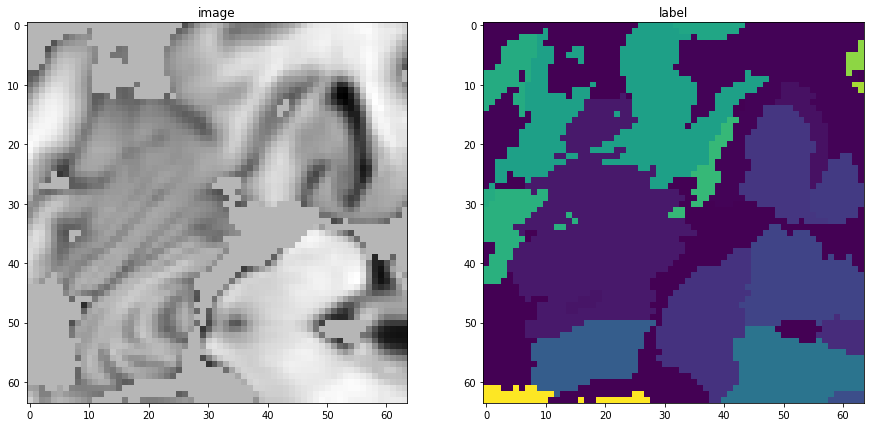

[ 0  1  4  5  6 11 12 13 14 15 18 21 25 26 27 34 45 49 50 52 54 56 59 73
 76 88]


In [14]:
H=60

test_data = first(train_loader)
image, label = (test_data["image"][0][0], test_data["label"][0][0])
print(test_data['image'].shape, test_data['label'].shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f"image dtype: {image.dtype}, label dtype: {label.dtype}")
# plot the slice [:, :, 80]
plt.figure("check", (15, 10))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, H], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, H])
# plt.subplot(1, 4, 3)
# plt.title("brain")
# plt.imshow(brain[:, :, H], cmap="gray")
# plt.subplot(1, 4, 4)
# plt.title("mask")
# plt.imshow(mask[:, :, H])
plt.show()

print(np.unique(label))

In [15]:
np.unique(label), label

(array([ 0,  1,  4,  5,  6, 11, 12, 13, 14, 15, 18, 21, 25, 26, 27, 34, 45,
        49, 50, 52, 54, 56, 59, 73, 76, 88], dtype=uint8),
 tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  1,  1,  1],
          [ 0,  0,  0,  ...,  1,  1,  1],
          [ 0,  0,  0,  ...,  1,  1,  1]],
 
         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  1,  1,  1],
          [ 0,  0,  0,  ...,  1,  1,  1],
          [ 0,  0,  0,  ...,  1,  1, 73]],
 
         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  1,  1, 73],
          [ 0,  0,  0,  ..., 73, 73, 73],
          [ 0,  0,  0,  ..., 73, 73, 73]],
 
         ...,
 
         [[ 0,  0,  0,  ..., 88, 88, 88

In [16]:
image

tensor([[[-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         ...,
         [-0.0000, -0.0000, -0.0000,  ...,  0.9966,  0.9461,  0.8111],
         [-0.0000,  0.0000,  0.0000,  ...,  0.8535,  0.7385,  0.5542],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.5697,  0.5543,  0.4211]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         ...,
         [-0.0000, -0.0000, -0.0000,  ...,  1.0849,  0.8519,  0.4598],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.7768,  0.3907,  0.0475],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.3884,  0.0697, -0.2468]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0

-3.9864370822906494 1.9250527620315552


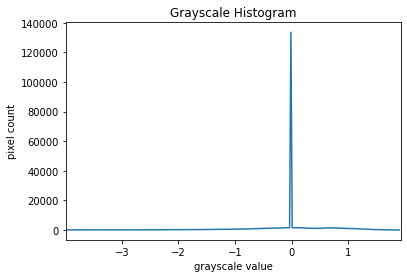

In [18]:
pixel_min, pixel_max = image.min().item(), image.max().item()
print(pixel_min, pixel_max)
histogram, bin_edges = np.histogram(image, bins=256, range=(pixel_min, pixel_max))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([pixel_min, pixel_max])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

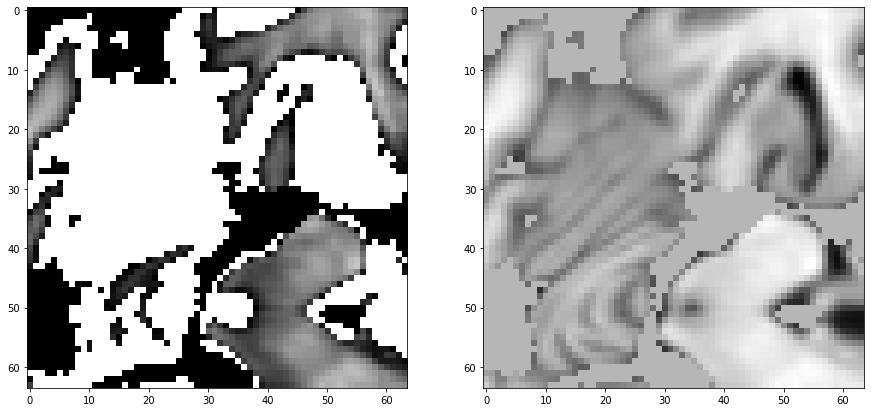

In [19]:
new_img = np.where(image < 0, 2, image)
new_img.shape
plt.figure("check", (15, 10))
plt.title("image")
plt.subplot(1, 2, 1)
plt.imshow(new_img[:, :, H], cmap="gray")
# plt.imshow(new_img[:, :, H])
plt.subplot(1, 2, 2)
plt.imshow(image[:, :, H], cmap="gray")

In [20]:
new_img[:, :, H]

array([[-0.        , -0.        , -0.        , ...,  0.9503681 ,
         0.8475017 ,  0.6121518 ],
       [-0.        , -0.        , -0.        , ...,  1.1128862 ,
         0.97549444,  0.68231505],
       [-0.        , -0.        , -0.        , ...,  0.98591965,
         0.65584195,  0.24865425],
       ...,
       [ 2.        ,  2.        ,  2.        , ...,  0.8932964 ,
         0.7096675 ,  0.5807393 ],
       [ 0.08681662,  2.        ,  2.        , ...,  1.0102619 ,
         0.90664905,  0.8261692 ],
       [ 0.5103806 ,  2.        ,  2.        , ...,  1.1441758 ,
         1.1188741 ,  1.0724839 ]], dtype=float32)

In [21]:
test_data['image'].shape

torch.Size([12, 1, 64, 64, 64])

In [22]:
label[:, :, H]

tensor([[ 0,  0,  0,  ...,  1,  1,  1],
        [ 0,  0,  0,  ...,  1,  1,  1],
        [ 0,  0,  0,  ...,  1,  1,  1],
        ...,
        [88, 88, 88,  ..., 34, 34, 34],
        [88, 88, 88,  ..., 21, 21, 21],
        [88, 88, 88,  ..., 21, 21, 21]], dtype=torch.uint8)

In [23]:
image[:, :, H]

tensor([[-0.0000, -0.0000, -0.0000,  ...,  0.9504,  0.8475,  0.6122],
        [-0.0000, -0.0000, -0.0000,  ...,  1.1129,  0.9755,  0.6823],
        [-0.0000, -0.0000, -0.0000,  ...,  0.9859,  0.6558,  0.2487],
        ...,
        [-0.4757, -0.5259, -1.1418,  ...,  0.8933,  0.7097,  0.5807],
        [ 0.0868, -0.3005, -1.1343,  ...,  1.0103,  0.9066,  0.8262],
        [ 0.5104, -0.0761, -0.8429,  ...,  1.1442,  1.1189,  1.0725]])

In [24]:
test_data.keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms', 'resample_flag', 'anisotrophy_flag'])

In [25]:
test_data['image_meta_dict']

{'sizeof_hdr': tensor([348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348],
        dtype=torch.int32),
 'extents': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32),
 'session_error': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int16),
 'dim_info': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8),
 'dim': tensor([[  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1],
         [  3, 186, 230, 230,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p